# EEL891 - Aprendizado de Máquina
# Trabalho 1: 
# Classificação: sistema de apoio à decisão p/ aprovação de crédito
# Aluno: Leonardo Gomes de Castro e Silva
# ID do Kaggle: 7074490

# Introdução

O trabalho tem como objetivo a construção de um modelo de aprendizado de máquina para classificação de aprovação de crédito.
Dessa forma, utiliza-se uma base de dados de solicitações de créditos rotulada com pessoas adimplentes, que honraram com os 
pagamentos, e inadimplentes que não pagaram e consequentemente geraram perdas para o financiador.


# Bibliotecas e Bases de Dados

Primeiramente, é necessário importar as bibliotecas de aprendizado de máquina, os conjuntos de dados de treino e teste
fornecidos no Kaggle. Além disso, também serão utilizados as bibliotecas de código aberto pandas, numpy e sci-kit para 
tratamento dos dados e construção do modelo.

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble     import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
data = pd.read_csv('conjunto_de_treinamento.csv')
test = pd.read_csv('conjunto_de_teste.csv')

# Tratamento e Pré-processamento dos Dados

A base de dados possui diversas informações a respeito dos solicitante, como estado civil, grau de instrução, idade.

In [3]:
data.head(10)

,id_solicitante,produto_solicitado,dia_vencimento,forma_envio_solicitacao,tipo_endereco,sexo,idade,estado_civil,qtde_dependentes,grau_instrucao,...,possui_telefone_trabalho,codigo_area_telefone_trabalho,meses_no_trabalho,profissao,ocupacao,profissao_companheiro,grau_instrucao_companheiro,local_onde_reside,local_onde_trabalha,inadimplente
0,1,1,10,presencial,1,M,85,2,0,0,...,N,,0,9.0,1.0,0.0,0.0,600.0,600.0,0
1,2,1,25,internet,1,F,38,1,0,0,...,N,,0,2.0,5.0,NaN,NaN,492.0,492.0,0
2,3,1,20,internet,1,F,37,2,0,0,...,N,,0,NaN,NaN,NaN,NaN,450.0,450.0,1
3,4,1,20,internet,1,M,37,1,1,0,...,Y,54,0,9.0,2.0,NaN,NaN,932.0,932.0,1
4,5,7,1,internet,1,F,51,1,3,0,...,N,,0,9.0,5.0,NaN,NaN,440.0,440.0,1
5,6,1,20,presencial,1,M,21,1,1,0,...,Y,107,0,9.0,2.0,0.0,0.0,628.0,628.0,1
6,7,1,15,presencial,1,F,64,4,2,0,...,N,,0,10.0,1.0,0.0,0.0,190.0,190.0,1
7,8,1,5,internet,1,F,20,1,0,0,...,N,,0,NaN,NaN,NaN,NaN,299.0,299.0,1
8,9,2,25,internet,1,F,39,2,2,0,...,Y,69,0,9.0,2.0,9.0,4.0,756.0,756.0,0
9,10,1,10,presencial,1,M,44,2,2,0,...,N,,0,9.0,2.0,16.0,4.0,960.0,960.0,1


Antes de construir o modelo, é necessário realizar um tratamento e pré-processamento dos dados. Inicialmente, substitui-se qualquer valor vazio ou null (NaN) por 0. Após isso, algumas características são descartadas no conjunto de teste e treino por serem redundantes, possuírem quase nenhum valor ou ser irrelevante para a predição do modelo. Uma forma de identificar os dados redundantes é através da matriz de correlação.

In [4]:
data = data.replace(np.nan,0)
data = data.replace('',0)

test = test.replace(np.nan,0)
test = test.replace('',0)

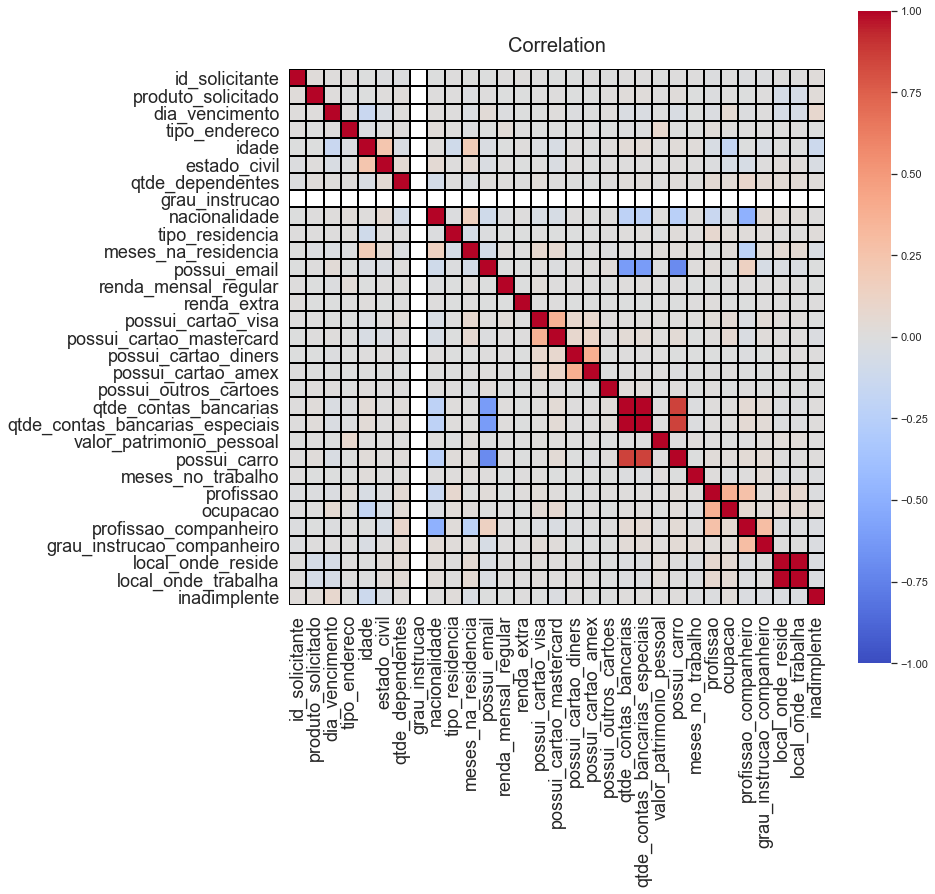

In [5]:
id_solicitante_test = test["id_solicitante"].to_frame()

sns.set(font_scale=10)
f = plt.figure(figsize=(12, 12))

sns.set_theme(style="white")

heatmap = sns.heatmap(data.corr(),vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=1, linecolor='black',square=True)

heatmap.set_title('Correlation', fontdict={'fontsize':20}, pad=18)

size = heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize = 18)
size = heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize = 18)

Eliminando as caracteristicas irrelevantes e/ou com dupla representação:

In [6]:
data = data.drop(['qtde_contas_bancarias','local_onde_reside','grau_instrucao','id_solicitante','estado_onde_nasceu','estado_onde_reside','estado_onde_trabalha','codigo_area_telefone_trabalho','codigo_area_telefone_residencial','tipo_residencia','meses_na_residencia','profissao_companheiro','grau_instrucao_companheiro','ocupacao','profissao'],axis=1)
test = test.drop(['qtde_contas_bancarias','local_onde_reside','grau_instrucao','id_solicitante','estado_onde_nasceu','estado_onde_reside','estado_onde_trabalha','codigo_area_telefone_trabalho','codigo_area_telefone_residencial','tipo_residencia','meses_na_residencia','profissao_companheiro','grau_instrucao_companheiro','ocupacao','profissao'],axis=1)

Transformando as colunas com mais de dois valores diferentes nas amostras com One-Hot Encoding

In [7]:
data = pd.get_dummies(data,columns=['forma_envio_solicitacao','sexo'])
test = pd.get_dummies(test,columns=['forma_envio_solicitacao','sexo'])

Já para as colunas que possuem apenas duas opções, usa-se a binarização para transformá-las em características numéricas e
atender a restrição do classificador.

In [8]:
binarizer = LabelBinarizer()
for indice in ['possui_telefone_residencial','possui_telefone_celular','possui_telefone_trabalho','vinculo_formal_com_empresa']:
    data[indice] = binarizer.fit_transform(data[indice])

binarizer = LabelBinarizer()
for indice in ['possui_telefone_residencial','possui_telefone_celular','possui_telefone_trabalho','vinculo_formal_com_empresa']:
    test[indice] = binarizer.fit_transform(test[indice])

In [9]:
data.head(10)

,produto_solicitado,dia_vencimento,tipo_endereco,idade,estado_civil,qtde_dependentes,nacionalidade,possui_telefone_residencial,possui_telefone_celular,possui_email,...,meses_no_trabalho,local_onde_trabalha,inadimplente,forma_envio_solicitacao_correio,forma_envio_solicitacao_internet,forma_envio_solicitacao_presencial,sexo_,sexo_F,sexo_M,sexo_N
0,1,10,1,85,2,0,1,1,0,0,...,0,600.0,0,0,0,1,0,0,1,0
1,1,25,1,38,1,0,1,1,0,1,...,0,492.0,0,0,1,0,0,1,0,0
2,1,20,1,37,2,0,1,1,0,1,...,0,450.0,1,0,1,0,0,1,0,0
3,1,20,1,37,1,1,1,1,0,1,...,0,932.0,1,0,1,0,0,0,1,0
4,7,1,1,51,1,3,1,1,0,1,...,0,440.0,1,0,1,0,0,1,0,0
5,1,20,1,21,1,1,1,1,0,0,...,0,628.0,1,0,0,1,0,0,1,0
6,1,15,1,64,4,2,1,1,0,1,...,0,190.0,1,0,0,1,0,1,0,0
7,1,5,1,20,1,0,1,1,0,1,...,0,299.0,1,0,1,0,0,1,0,0
8,2,25,1,39,2,2,1,1,0,1,...,0,756.0,0,0,1,0,0,1,0,0
9,1,10,1,44,2,2,1,0,0,0,...,0,960.0,1,0,0,1,0,0,1,0


Com os dados tratados e processados, é necessário embaralhar a base de dados, pois precisa-se garantir que não haverá viés na seleção. e divisão dos dados de treino e teste. A coluna inadimplente será o resultado da predição, portanto ela é definida como o alvo (target).

In [10]:
shuffled_data = data.sample(frac=1,random_state=12345)
x = shuffled_data.loc[:,shuffled_data.columns!='inadimplente'].values
y = shuffled_data.loc[:,shuffled_data.columns=='inadimplente'].values

Alem do embaralhamento, a base de dados será dividida em 70% para treino e 30% para teste.

In [11]:
x_training, x_test, y_training, y_test = train_test_split(
    x,
    y.ravel(),
    train_size=0.7,
    shuffle=True,
    random_state=0
    )

Para melhorar o desempenho do classificador, pode-se ajustar a escala dos dados

In [12]:
fix_scale = MinMaxScaler()
fix_scale.fit(x_training)

fix_scale_test = MinMaxScaler()
fix_scale_test.fit(test)
test = fix_scale_test.transform(test)

x_training = fix_scale.transform(x_training)
x_test  = fix_scale.transform(x_test)

# Modelos de Machine Learning Testados

Foram testados diversos tipos de classificador para validar qual aprensentaria a melhor acurácia. O código comentado abaixo
apresenta alguns desses modelos:

In [13]:
#classifier = GradientBoostingClassifier()
#classifier = RandomForestClassifier() 
#classifier = SVC() #
#classifier = DecisionTreeClassifier()
#classifier = LinearDiscriminantAnalysis()
#classifier = KNeighborsClassifier()

# Definição do Modelo e Otimização dos Parâmetros

Após definido o melhor modelo de classificação como sendo o da floresta aleatória (RandomForestClassifier), executou-se uma otimização por hiperparâmetros (Hyperparameter Tuning) para identificar quais parâmetros da floresta aleatória traz o melhor resultado. O código comentado abaixo apresenta como a otimização foi executada:

In [14]:
#from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 1000)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(1, 500, num = 500)]
#max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [1,2,3,4, 5,6,7,8,9, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1,2,3,4, 5,6,7,8,9, 10]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}

#rf = RandomForestClassifier(max_depth=8)
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42,scoring='accuracy', n_jobs = -1)
#rf_random.fit(x_training,y_training)
#rf_random.best_params_

Após a otimização, o modelo de floresta aleatória apresentou os melhores resultados com os seguintes parâmetros abaixo:

In [15]:
classifier = RandomForestClassifier(max_depth=8, n_estimators=494,min_samples_split=5,min_samples_leaf=3,bootstrap='true',max_features='sqrt')
classifier = classifier.fit(x_training,y_training)

In [16]:
y_answer_training = classifier.predict(x_training)
y_answer_test = classifier.predict(x_test)

# Resultado

Para concluir, verifiquemos os resultados de acurácia dentro dos conjuntos de treino e de teste


In [17]:
answer_test = classifier.predict(test)
answer_df = pd.DataFrame(answer_test)
answer_df = answer_df.rename(columns={0:'inadimplente'})
answer_final = id_solicitante_test.join(answer_df)
answer_final.to_csv('answer.csv',index=False)


print ("\nConjunto de Treino\n")

total   = len(y_training)
correct = sum(y_answer_training==y_training)
wrong   = sum(y_answer_training!=y_training)

acuracy = correct / total

print ("Acurácia = %.1f %%" % (100*acuracy))

print ("\nCorretas:" , correct)
print ("Erradas: " , wrong)
print ("Total: " , total)

print ("\nConjunto de Teste\n")

total   = len(y_test)
correct = sum(y_answer_test==y_test)
wrong   = sum(y_answer_test!=y_test)

acuracy = correct / total

print ("Acurácia = %.1f %%" % (100*acuracy))

print ("\nCorretas:" , correct)
print ("Erradas: " , wrong)
print ("Total: " , total)


Conjunto de Treino

Acurácia = 64.5 %

Corretas: 9027
Erradas:  4973
Total:  14000

Conjunto de Teste

Acurácia = 58.8 %

Corretas: 3528
Erradas:  2472
Total:  6000
